Deep Learning techniques can be used to predict various outcomes including but not limited to future sales. Your task is to create a deep learning model of the Long Short Term Memory which is a type of Recurrent Neural Network . 

###### Importing libraries  

In [26]:
import sys 
sys.path.append('..')
import warnings
warnings.simplefilter("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from Scripts.Data_cleaning import load_data,clean_data
from Scripts.preprocessing import preprocess

###### Load datasets  

In [9]:
train_df = load_data('../data/train-data.csv')
train_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,...,Customers,Open,Promo,StateHoliday,SchoolHoliday,Days,months,Years,DayOfYear,WeekOfYear
0,1,c,a,1270.0,9,2008,0,0,0,"0,0,0,0",...,555.0,1,1,0,1,31,7,2015,212,31
1,1,c,a,1270.0,9,2008,0,0,0,"0,0,0,0",...,546.0,1,1,0,1,30,7,2015,211,31
2,1,c,a,1270.0,9,2008,0,0,0,"0,0,0,0",...,523.0,1,1,0,1,29,7,2015,210,31
3,1,c,a,1270.0,9,2008,0,0,0,"0,0,0,0",...,560.0,1,1,0,1,28,7,2015,209,31
4,1,c,a,1270.0,9,2008,0,0,0,"0,0,0,0",...,612.0,1,1,0,1,27,7,2015,208,31


##### preprocessing 

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014567 entries, 0 to 1014566
Data columns (total 23 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1014567 non-null  int64  
 1   StoreType                  1014567 non-null  object 
 2   Assortment                 1014567 non-null  object 
 3   CompetitionDistance        1014567 non-null  float64
 4   CompetitionOpenSinceMonth  1014567 non-null  int64  
 5   CompetitionOpenSinceYear   1014567 non-null  int64  
 6   Promo2                     1014567 non-null  int64  
 7   Promo2SinceWeek            1014567 non-null  int64  
 8   Promo2SinceYear            1014567 non-null  int64  
 9   PromoInterval              1014567 non-null  object 
 10  DayOfWeek                  1014567 non-null  int64  
 11  Date                       1014567 non-null  object 
 12  Sales                      1014567 non-null  float64
 13  Customers   

In [11]:
train_df.isna().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
Days                         0
months                       0
Years                        0
DayOfYear                    0
WeekOfYear                   0
dtype: int64

In [12]:
#converting date column to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])

In [15]:
sales = train_df[['Date','Sales']]
sales.head()

,Date,Sales
0,2015-07-31,5263.0
1,2015-07-30,5020.0
2,2015-07-29,4782.0
3,2015-07-28,5011.0
4,2015-07-27,6102.0


In [20]:
# group by dates 
Daily_sales = sales.groupby('Date').mean()
Daily_sales

,Sales
Date,
2013-01-01,77.148515
2013-01-02,5949.892086
2013-01-03,5503.840827
2013-01-04,5791.136691
2013-01-05,5127.290468
...,...
2015-07-27,7956.071942
2015-07-28,7490.580935
2015-07-29,7129.690647


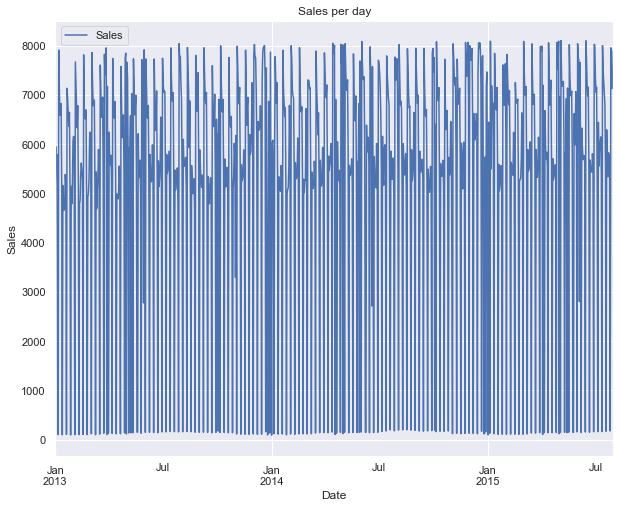

In [28]:
#plot sales per day time serie graph 
Daily_sales.plot(figsize=(10,8))
plt.title('Sales per day')
plt.ylabel('Sales');

###### check stationarilty 

In [34]:
#use ADF to check for stationarity 
adf_results = adfuller(Daily_sales['Sales'].values,autolag='AIC')

In [40]:
dfoutput = pd.Series(adf_results[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in adf_results[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)


Test Statistic                -6.142609e+00
p-value                        7.904646e-08
#Lags Used                     2.100000e+01
Number of Observations Used    9.200000e+02
Critical Value (1%)           -3.437478e+00
Critical Value (5%)           -2.864687e+00
Critical Value (10%)          -2.568445e+00
dtype: float64


Test statistic is -6.142609 and is less than any critical values. Additionaly p-value is less than significance level of 0.05. Therefore, we can reject the null hypothesis and stay that the data is stationary

###### Scale the data 

In [50]:
Daily_sales_scaled = Daily_sales.copy()


In [53]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_data = scaler.fit_transform(Daily_sales_scaled['Sales'].values.reshape(-1,1))
Daily_sales_scaled['Sales'] = scaled_data

In [54]:
Daily_sales_scaled

,Sales
Date,
2013-01-01,-1.000000
2013-01-02,0.463342
2013-01-03,0.352197
2013-01-04,0.423784
2013-01-05,0.258370
...,...
2015-07-27,0.963233
2015-07-28,0.847244
2015-07-29,0.757319


###### plot timeserie of scaled and un-scaled data 

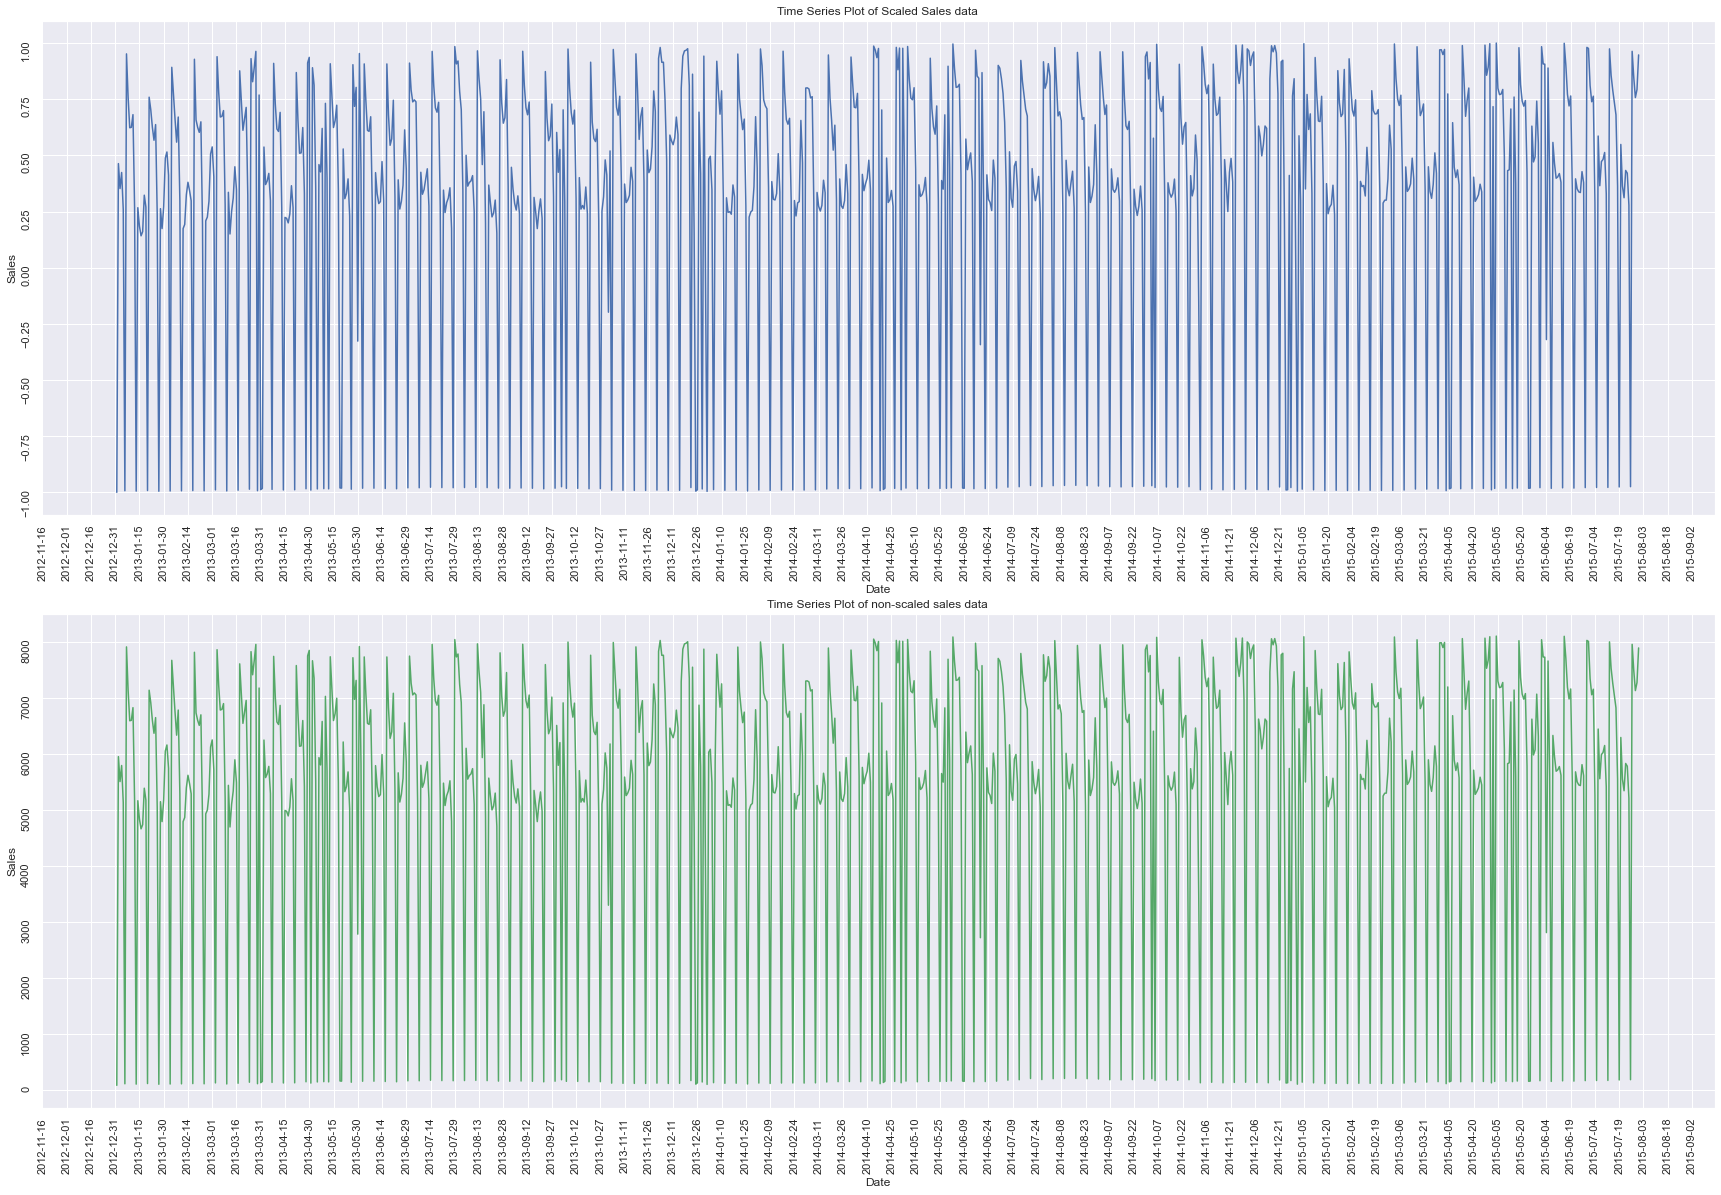

In [56]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(Daily_sales_scaled.index, Daily_sales_scaled.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales')
ax1.title.set_text('Time Series Plot of Scaled Sales data')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(Daily_sales.index, Daily_sales.Sales, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Sales')
ax2.title.set_text('Time Series Plot of non-scaled sales data')
ax2.grid(True)
plt.show()

###### plot autocorrelation and partial autocorrelation 

In [57]:
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(10, 8))
    plt.title(f"{prefix}  Autocorrelations of Scaled sales data")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()

In [58]:
acfSalesScaled = acf(Daily_sales_scaled.Sales.values, fft=True, nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)

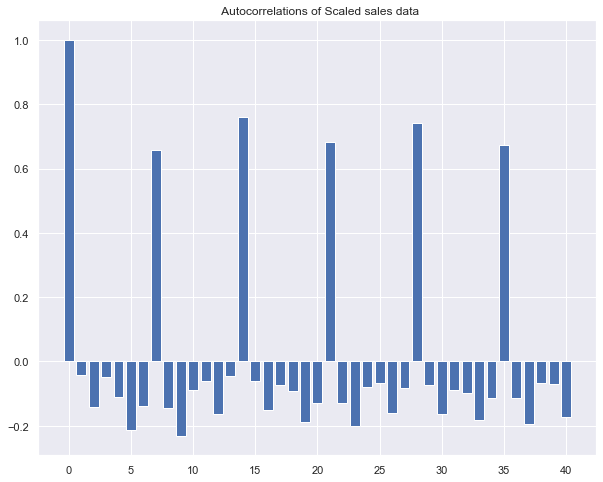

In [59]:
corrPlots(acfSalesScaledNp, '')

In [60]:
pacfSalesScaled = pacf(Daily_sales_scaled.Sales.values, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)

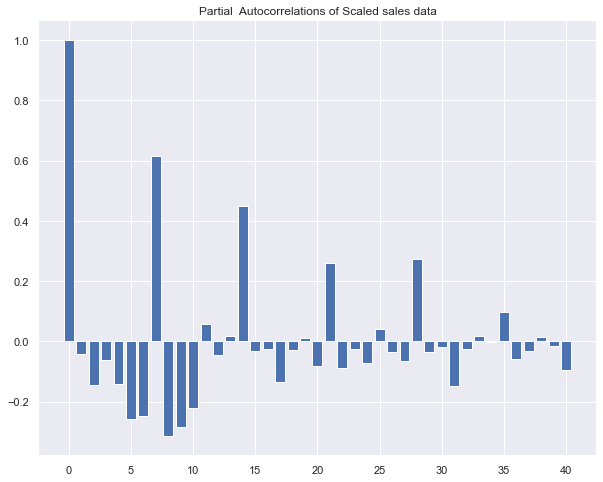

In [61]:
corrPlots(pacfSalesScaledNp, 'Partial')

#### Training and validation Set Format 

In [62]:
SIZE = len(Daily_sales_scaled.Sales)
WINDOW_SIZE = 48
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 200

In [65]:
DateTrain = Daily_sales.index.values[0:BATCH_SIZE]
DateValid = Daily_sales.index.values[BATCH_SIZE:]
XTrain = Daily_sales_scaled.Sales.values[0:BATCH_SIZE].astype('float32')
XValid = Daily_sales_scaled.Sales.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (846, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (846,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [66]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([846, 1])

In [67]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

In [68]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True) 

In [71]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

In [72]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

In [73]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)